# Medical Image Classification

## 1. 데이터 준비: MedNIST dataset

In [ ]:
import os
print(os.getcwd())
!ls

/content
mednist.tar.gz	resized  sample_data


In [ ]:
# 데이터 다운로드
!wget https://raw.githubusercontent.com/mi2rl/datasets/master/mednist.tar.gz

--2021-05-28 07:23:18--  https://raw.githubusercontent.com/mi2rl/datasets/master/mednist.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62087736 (59M) [application/octet-stream]
Saving to: ‘mednist.tar.gz’

mednist.tar.gz      100%[===================>]  59.21M  57.6MB/s    in 1.0s    

2021-05-28 07:23:19 (57.6 MB/s) - ‘mednist.tar.gz’ saved [62087736/62087736]



In [ ]:
# 압축 풀기
!tar xzf mednist.tar.gz

In [ ]:
import os
import cv2
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [ ]:
dataDir = 'resized' # 데이터 위치
classNames = sorted(os.listdir(dataDir))                    # 각 클래스의 이름들
print(os.listdir(dataDir))
numClass = len(classNames)                                  # Number of classes = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) 
              for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # 각 클래스 별 파일 이름들
numEach = [len(imageFiles[i]) for i in range(numClass)]     # 각 클래스 별 파일 갯수
imageFilesList = []                                         # 모든 파일이름
imageClass = []                                             # 각각의 파일들에 대한 클래스 

for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
    
numTotal = len(imageClass)                                            # 전체 파일 갯수
imageWidth, imageHeight = Image.open(imageFilesList[0]).size          # 각 영상의 사이즈(width, height)

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

['AbdomenCT', 'BreastMRI', 'HeadCT', 'ChestCT', 'CXR', 'Hand']
There are 58954 images in 6 distinct categories
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]
Image dimensions: 64 x 64


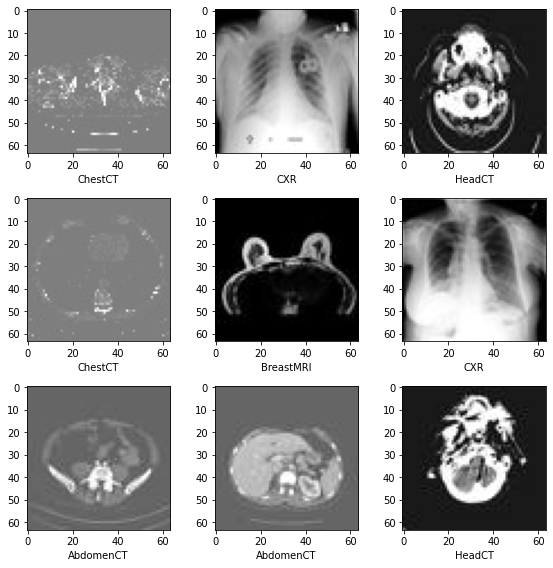

In [ ]:
# 전체 이미지 중 9개를 랜덤으로 골라 3x3으로 레이블과 함께 그리기
# -- 여러번 실행하며 이미지들을 살펴보세요 --

plt.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)): 
    im = Image.open(imageFilesList[k])                      
    arr = np.array(im)
    plt.subplot(3,3,i+1)
    plt.xlabel(classNames[imageClass[k]])
    plt.imshow(arr,cmap='gray',vmin=0,vmax=255)
plt.tight_layout()
plt.show()

In [ ]:
# 이미지 리스트 살펴보기
imageFilesList[0:10]

['resized/AbdomenCT/006963.jpeg',
 'resized/AbdomenCT/007256.jpeg',
 'resized/AbdomenCT/007961.jpeg',
 'resized/AbdomenCT/003176.jpeg',
 'resized/AbdomenCT/001659.jpeg',
 'resized/AbdomenCT/005592.jpeg',
 'resized/AbdomenCT/007188.jpeg',
 'resized/AbdomenCT/008609.jpeg',
 'resized/AbdomenCT/007330.jpeg',
 'resized/AbdomenCT/007248.jpeg']

## 2. VGG16을 이용한 분류 실습 (w/ ImageNet pre-trained weight)
![대체 텍스트](https://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png)

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### ### 2.1. [Quiz] 순서가 섞인 layer들을 VGG16 구성에 맞게 배치해보세요.

In [ ]:
inputs = Input(shape=(224, 224, 3,), name="VGGInput")

x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=4096, kernel_size=(7,7), padding='valid', activation='relu')(x)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
pred = Dense(1000, activation='softmax')(x)

model = Model(inputs=inputs, outputs=pred)

model.summary()

**VGG16**

`keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)`

VGG16 model, with weights pre-trained on ImageNet.

This model can be built both with 'channels_first' data format (channels, height, width) or 'channels_last' data format (height, width, channels).

The default input size for this model is 224x224.

**Arguments**

* include_top: whether to include the 3 fully-connected layers at the top of the network.
* weights: one of None (random initialization) or 'imagenet' (pre-training on ImageNet).
* input_tensor: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
* input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with 'channels_last' data format) or (3, 224, 224) (with 'channels_first' data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.
* pooling: Optional pooling mode for feature extraction when include_top is False.
* classes: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.

**tf.keras에서 제공되는 모델들 참고:** https://www.tensorflow.org/api_docs/python/tf/keras/applications

### 2.2. VGG16 모델 불러오기

In [ ]:
from tensorflow.keras.applications import vgg16

# VGG16 모델 불러오기
model = vgg16.VGG16()

# 모델의 모양을 보여준다.
model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

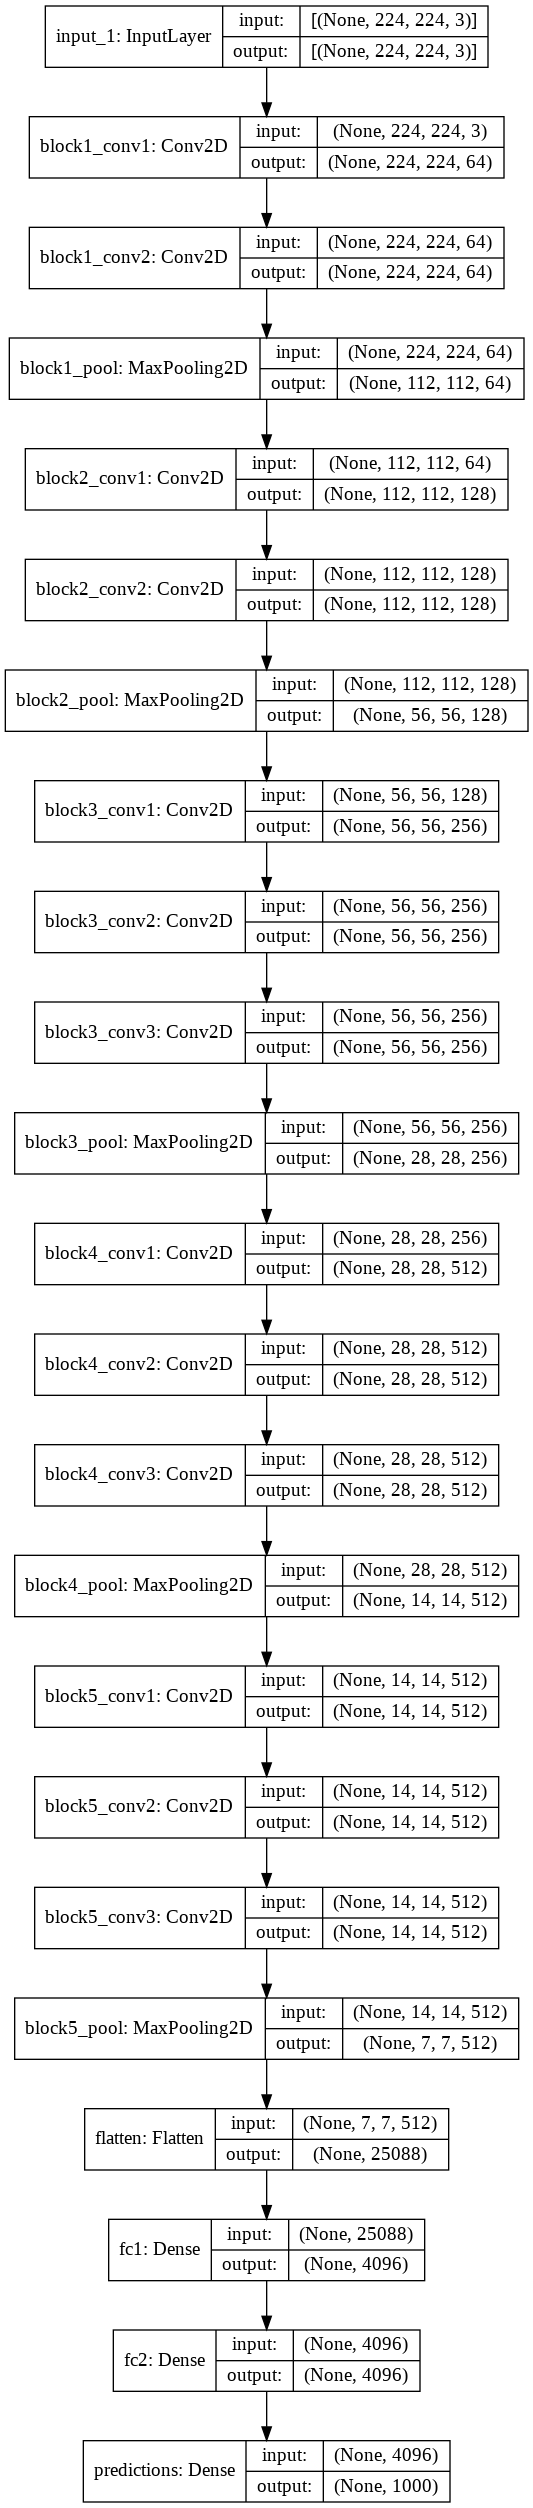

In [ ]:
# Model 구성도 plot
import tensorflow as tf
from IPython.display import Image

tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True, show_layer_names=True)
Image(filename='vgg16.png')

In [ ]:
# VGG16 모델을 이용해 prediction 하는 함수
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from IPython.display import display # 이미지 출력 함수

def predict_vgg16(model, filename) :
    # 이미지 파일을 읽고 화면에 표시
    image = load_img(filename)
    display(image)

    # 모델 사이즈로 이미지 파일을 읽기
    image = load_img(filename, target_size=(224, 224))

    # 이미지 데이터를 numpy로 변환
    image = img_to_array(image)

    # vgg16.preprocess_input()을 호출하기 위해 차원을 조정
    # 보통 모델을 여러 이미지를 한번에 호출. 
    # 맨 앞의 1 : 이미지 갯수가 1개라는 것.
    # 두번째 224 : 가로
    # 세번째 224 : 세로
    # 네번째 3 : R, G, B 3개
    image = image.reshape((1, 224, 224, 3))

    # VGG16 모델 호출을 위해 데이터 전처리.
    # -255 ~ 255 사이 값으로 정규화한다.
    # 그리고 RGB를 BGR순으로 바꾼다.
    image = vgg16.preprocess_input(image)


    # 이미지를 모델에 적용
    yhat = model.predict(image)

    # 모델 적용된 결과를 파싱
    label = vgg16.decode_predictions(yhat)

    # 가장 확률이 높은 결과를 획득
    label = label[0][0]

    # 라벨과 라벨을 예측한 확률을 출력
    print('%s (%.2f%%)' % (label[1], label[2]*100))

In [ ]:
files = imageFilesList[0:10]

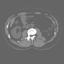

40960/35363 [==================================] - 0s 0us/step
spotlight (10.62%)


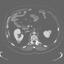

fireboat (10.42%)


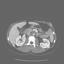

container_ship (14.58%)


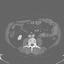

fireboat (42.14%)


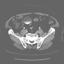

container_ship (42.40%)


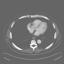

airship (9.40%)


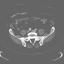

container_ship (40.54%)


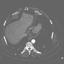

container_ship (37.74%)


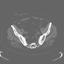

fireboat (23.05%)


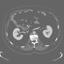

fireboat (14.20%)


In [ ]:
for file in files:
    predict_vgg16(model, file)

### 2.3. Dataset 나누기: Train / Validation / Test

In [ ]:
validFrac = 0.2   # Define the fraction of images to move to validation dataset
testFrac = 0.2    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Randomly reassign images, random.random(): return 0 ~ 1(float)
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"\nValidation =",nValid,"\nTesting =",nTest)

Training images = 35200 
Validation = 11975 
Testing = 11779


In [ ]:
!mkdir ./train
!mkdir ./valid
!mkdir ./test

In [ ]:
import shutil
from tqdm import tqdm

root, clas, src = imageFilesList[trainList[0]].split('/')
print(imageFilesList[trainList[0]])
print(root)
print(clas)
print(src)

dest = os.path.join('./train',clas,src)
print(dest)

resized/AbdomenCT/006963.jpeg
resized
AbdomenCT
006963.jpeg
./train/AbdomenCT/006963.jpeg


In [ ]:
import shutil
from tqdm import tqdm

for i in tqdm(range(len(trainList))):
  root, clas, src = imageFilesList[trainList[i]].split('/')
  dest = os.path.join('./train',clas,src)
  if not os.path.exists(os.path.join('./train',clas)):
    os.mkdir(os.path.join('./train',clas))
  shutil.copy(imageFilesList[trainList[i]], dest)
  
for i in tqdm(range(len(validList))):
  root, clas, src = imageFilesList[validList[i]].split('/')
  dest = os.path.join('./valid',clas,src)
  if not os.path.exists(os.path.join('./valid',clas)):
    os.mkdir(os.path.join('./valid',clas))
  shutil.copy(imageFilesList[validList[i]], dest)
  
    
for i in tqdm(range(len(testList))):
  root, clas, src = imageFilesList[testList[i]].split('/')
  dest = os.path.join('./test',clas,src)
  if not os.path.exists(os.path.join('./test',clas)):
    os.mkdir(os.path.join('./test',clas))
  shutil.copy(imageFilesList[testList[i]], dest)

100%|██████████| 11779/11779 [00:02<00:00, 5766.64it/s]


### 2.4. Image Data Generator 정의 (+Data Augmentation)
**Keras API - ImageDataGenerator: 일정한 규칙으로 만들어진 폴더구조에서 데이터셋을 자동으로 불러와 학습에 사용할 수 있게 도와주는 API**
![대체 텍스트](https://miro.medium.com/max/875/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)
https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720  
**Data augmentation: 데이터에 다양한 형태의 변화를 임의로 생성하여 데이터의 갯수와 다양성을 증가시키는 방법**
![대체 텍스트](https://miro.medium.com/max/1250/1*rvwzKkvhlDN3Wo_4Oay_4Q.png)
https://medium.com/@thimblot/data-augmentation-boost-your-image-dataset-with-few-lines-of-python-155c2dc1baec

In [ ]:
import numpy as np

arr = np.array([[1, 2], [4, 5]])
#print(arr.shape)
#print(arr)

expansion_0 = np.expand_dims(arr, axis=0)
print(expansion_0.shape)
#print(expansion_0)
print(expansion_0[0,:,:])
#print(expansion_0[1,:,:])


(1, 2, 2)
[[1 2]
 [4 5]]


In [ ]:
expansion_1 = np.expand_dims(arr, axis=1)
print(expansion_1.shape)
#print(expansion_1)
print(expansion_1[0,:,:])
print('\n')
print(expansion_1[1,:,:])

(2, 1, 2)
[[1 2]]


[[4 5]]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dropout

def preprocess_input_vgg(x):
  X = np.expand_dims(x, axis=0) # expand_dims(arr, axis): 차원 확장, axis: 확장할 축의 위치 -> (samples, size1,size2,channels)와 같이 차원을 확장합니다.
  X = preprocess_input(X) # The preprocess_input function is meant to adequate your image to the format the model requires.
  return X[0]

train_dir = './train'
validation_dir = './valid'
test_dir = './test'
batch_size = 32
image_size = 224

# 학습에 사용될 이미지 데이터 생성기
train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input_vgg, # 이미지 처리전에 주어진 값을 곱해 크기를 조정?
      rotation_range=20, # 회전 최대 20도
      width_shift_range=0.2, # 좌우 이동
      height_shift_range=0.2, # 상하 이동
      horizontal_flip=True, # 좌우 반전
      vertical_flip=True, # 상하 반전
      )
 
# 검증에 사용될 이미지 데이터 생성기
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

# 테스트에 사용될 이미지 데이터 생성기
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)


# 학습에 사용될 데이터 생성기  
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

# 검증에 사용될 데이터 생성기
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_num=len(train_generator.class_indices)

custom_labels = list(validation_generator.class_indices.keys())

Found 35200 images belonging to 6 classes.
Found 11975 images belonging to 6 classes.


### 2.5. VGG16 as a Feature Extractor

In [ ]:
# 모델 불러오기
vgg_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
vgg_model.summary()

# Convolution Layer를 학습되지 않도록 고정 
for layer in vgg_model.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
# 새로운 모델 생성하기
last = vgg_model.output
 
# VGG16모델에 Fully Connected부분을 재구성해서 추가
x = Flatten()(last)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(class_num, activation='softmax')(x)

model = Model(vgg_model.input, pred)

In [ ]:
# 새로운 모델 요약
model.summary()

# 새로운 모델 저장
vgg16_model_path = 'vgg16_finetuning.h5'

model.save(vgg16_model_path)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 2.6. 새로운 모델 학습

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop

# 모델 로딩
model = load_model(vgg16_model_path)

# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

# 모델 학습
history = model.fit(
      x=train_generator,
      steps_per_epoch=100 ,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
 
# 모델 저장
model.save(vgg16_model_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/2
100/100 [==============================] - 97s 665ms/step - loss: 0.6510 - acc: 0.9459 - val_loss: 0.0053 - val_acc: 0.9992
Epoch 2/2
100/100 [==============================] - 65s 656ms/step - loss: 0.0736 - acc: 0.9922 - val_loss: 0.0078 - val_acc: 0.9990


### 2.7. 학습 결과 시각화

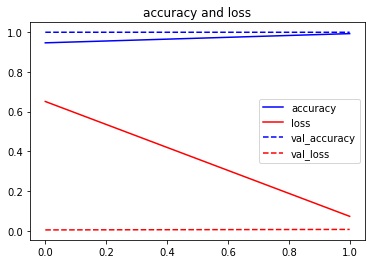

In [ ]:
acc = history.history['acc']
loss = history.history['loss']
valacc = history.history['val_acc']
valloss = history.history['val_loss']


epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='accuracy')
plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, valacc, 'b--', label='val_accuracy')
plt.plot(epochs, valloss, 'r--', label='val_loss')
plt.title('accuracy and loss')
plt.legend()
  
plt.show()

### 2.8. 학습된 모델을 이용해 Test 데이터에 대한 Prediction

In [ ]:
# 테스트에 사용될 데이터 생성기
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical',
        shuffle=False)

model.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)

Found 11779 images belonging to 6 classes.
92/92 [==============================] - 35s 268ms/step - loss: 0.0115 - acc: 0.9986


[0.011532312259078026, 0.9985567331314087]

## 3. VGG16을 이용한 분류 실습 (from Scratch)

In [ ]:
# 모델 불러오기
vgg_model = vgg16.VGG16(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
last = vgg_model.output

In [ ]:
# VGG16모델에 Fully Connected부분을 재구성해서 추가
x = Flatten()(last)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(class_num, activation='softmax')(x)

model = Model(vgg_model.input, pred)

In [ ]:
# 새로운 모델 요약
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# 새로운 모델 저장
vgg16_model_path = 'vgg16_scratch.h5'

model.save(vgg16_model_path)

In [ ]:
# 모델 로딩
model = load_model(vgg16_model_path)

# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

# 모델 학습
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100 ,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# 모델 저장
model.save(vgg16_model_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
100/100 [==============================] - 74s 725ms/step - loss: 1.2441 - acc: 0.5581 - val_loss: 0.3319 - val_acc: 0.8300
Epoch 2/2
100/100 [==============================] - 73s 729ms/step - loss: 0.3256 - acc: 0.8975 - val_loss: 0.2631 - val_acc: 0.9069


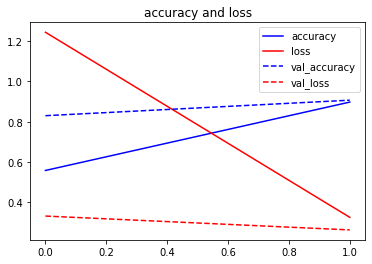

In [ ]:
acc = history.history['acc']
loss = history.history['loss']
valacc = history.history['val_acc']
valloss = history.history['val_loss']


epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='accuracy')
plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, valacc, 'b--', label='val_accuracy')
plt.plot(epochs, valloss, 'r--', label='val_loss')
plt.title('accuracy and loss')
plt.legend()
  
plt.show()

In [ ]:
# For prediction purposes
y_pred = model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
y_pred1 = np.argmax(y_pred, axis=1)

92/92 [==============================] - 20s 221ms/step


In [ ]:
## 4. Confusion Matrix Visualization

In [ ]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# y_test labeling
y_test = test_generator.labels

In [ ]:
# calculate confusion matrix for the predicted dataset
cm = confusion_matrix(y_test, y_pred1)

In [ ]:
# make a dataframe using cm array
df_cm = pd.DataFrame(cm, index = [i for i in classNames], columns = [i for i in classNames])

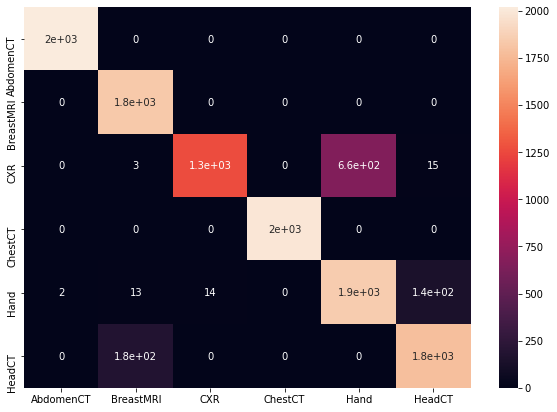

In [ ]:
# plot confusion matrix
plt.figure(figsize = (10, 7))
sn.heatmap(df_cm, annot=True)

In [ ]:
# classification report generation: precision, recall, f1-score. 
print(classification_report(y_test, y_pred1, target_names=classNames))

              precision    recall  f1-score   support

   AbdomenCT       0.99      0.93      0.96      2018
   BreastMRI       0.93      0.75      0.83      1829
         CXR       0.46      0.99      0.63      1943
     ChestCT       0.00      0.00      0.00      1994
        Hand       0.98      0.16      0.28      2025
      HeadCT       0.48      0.94      0.64      1970

    accuracy                           0.62     11779
   macro avg       0.64      0.63      0.55     11779
weighted avg       0.64      0.62      0.55     11779



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5. VGG16 + Grad-CAM

## 5. VGG16 + Grad-CAM
![대체 텍스트](https://camo.githubusercontent.com/450498bd998fd99d51b647d2b6c8631e94585522/687474703a2f2f692e696d6775722e636f6d2f4a614762645a352e706e67)
**Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via Gradient-based Localization**  
Ramprasaath R. Selvaraju, Abhishek Das, Ramakrishna Vedantam, Michael Cogswell, Devi Parikh, Dhruv Batra  
https://arxiv.org/abs/1610.02391  
  
**Example: 'Boxer'**  
![대체 텍스트](https://github.com/PowerOfCreation/keras-grad-cam/raw/master/examples/cat_dog.png)
![대체 텍스트](https://github.com/PowerOfCreation/keras-grad-cam/raw/master/examples/cat_dog_242_gradcam.jpg)
![대체 텍스트](https://github.com/PowerOfCreation/keras-grad-cam/raw/master/examples/cat_dog_242_guided_gradcam.jpg)

In [ ]:
inum = random.randrange(0,len(imageFilesList))
qimage0 = load_img(imageFilesList[inum], target_size=(224, 224))
qimage  = img_to_array(qimage0)
qimage  = qimage.reshape((1, 224, 224, 3))
qimage  = vgg16.preprocess_input(qimage)

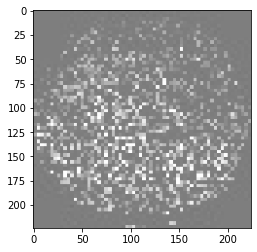

In [ ]:
plt.imshow(qimage0)

In [81]:
def grad_cam(input_model, image):
    nb_classes = 6  # 클래스 숫자(AbdomenCT, BreastMRI, CXR, ChestCT, Hand, HeadCT)
    preds = model.predict(image)
    predicted_label = np.argmax(preds[0]) # 분류된 클래스 중 제일 큰 값(예측률이 높은 값)

    grad_model = tf.keras.Model(
        [model.input], [model.get_layer('block5_conv3').output, model.output]
    )

    with tf.GradientTape() as tape: # 아래에 실행된 모든 연산을 'tape'에 저장
        image = tf.cast(image, tf.float32)
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, predicted_label]

    grad = tape.gradient(loss, conv_outputs)[0] # tape에 저장된 연산들의 gradient(기울기) 계산
    weights = tf.reduce_sum(grad, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)
    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    cam = cv2.applyColorMap(
        cv2.cvtColor((cam * 255).astype("uint8"), cv2.COLOR_GRAY2RGB), cv2.COLORMAP_JET
    )
    
    return np.uint8(cam), predicted_label

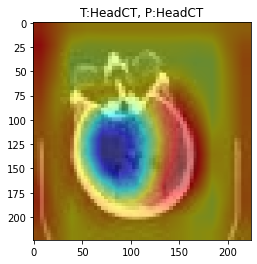

In [85]:
inum = random.randrange(0,len(imageFilesList))
qimage0 = load_img(imageFilesList[inum], target_size=(224, 224))
qimage  = img_to_array(qimage0)
qimage  = qimage.reshape((1, 224, 224, 3))
qimage  = vgg16.preprocess_input(qimage)

# CAM 출력
cam, plabel = grad_cam(model, qimage)
plt.title('T:'+classNames[imageClass[inum]]+', P:'+classNames[plabel])
plt.imshow(qimage0)
plt.imshow(cam, alpha=.5)